# Analysis and Prediction of the Drug Type for a patient given its information
![drug](drugs_image.jpg)

Can we predict a drug type for a patient depending on certain factors. Please note that it does not replace the need of physician's advice. However, this shows the prowess of Machine Learning Models to predict a drug prescription to near perfect levels.


This dataset contains information about drug classification based on patient general information and its diagnosis such as:

### Data Dictionary

|Feature|Description|
|-----|-----|
|Age| The age of the patient|
|Sex| The gender of the patient|
|BP| The Blood Pressure (High/Low/Normal)|
|Cholesterol| The Blood Cholesterol levels (High/Normal)|
|Na_to_K| Natrium (Sodium) to Potassium levels |
|Drug| The target variable with 5 Drug types|

[Dataset Resource](https://www.kaggle.com/datasets/jeevanrh/drug200csv)


## Goal:
Predict the drug type for the patient given the patient's attributes

---

In [3]:
#pip install imblearn

In [4]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# importing ML libraries
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import LinearSVC                   
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# Using Pipeline functions from imblearn instead of sklearn.
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline

# to save the model 
import pickle

# for conducting VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [5]:
# Loading the dataset
drugs = pd.read_csv('drugs.csv')

In [6]:
drugs.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [7]:
drugs.shape

(200, 6)

In [8]:
drugs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


## Data Exploration

In [9]:
for col in drugs.columns:
    print(col, drugs[col].nunique())

Age 57
Sex 2
BP 3
Cholesterol 2
Na_to_K 198
Drug 5


In [10]:
for col in drugs.columns:
    num = drugs[col].nunique()
    percentage = float(num) / drugs.shape[0] * 100
    print('{}, {}, {}'.format(col, num, percentage))

Age, 57, 28.499999999999996
Sex, 2, 1.0
BP, 3, 1.5
Cholesterol, 2, 1.0
Na_to_K, 198, 99.0
Drug, 5, 2.5


- It can be observed that `Age`, `Sex`, `BP`, `Cholestrol`, as well as our target variable, `Drug` are not continuous variables. They can be represented better as ordinal or categorical variables
- The only continuous variable is `NA_to_K`
    - For columns such as `NA_to_K` and `Age`, Binning can be done
- Apparently, there are no missing values 
- All the columns contain atleast 2 unique values. So none of the columns could be said to be of zero-variance


In [11]:
# Check for the duplicated samples
drugs.duplicated().sum()

0

The data looks to be in an okayish shape. Lets explore it to check it further and do whatever seems necessary

---

### Exploration of the Features
We are not having a lots of columns and every column seems to be an important part of the sample, it looks worthwhile to give each of them a brief look and do the necessary changes if required


### `Age`

In [12]:
print('The youngest is of age',drugs['Age'].min(), ', whereas the most senior is of age', drugs['Age'].max())

The youngest is of age 15 , whereas the most senior is of age 74


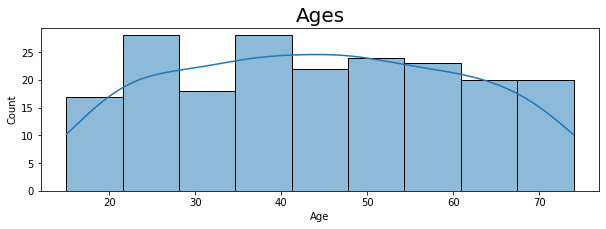

In [13]:
plt.figure(figsize=(10,3))
sns.histplot(drugs['Age'], kde=True)
plt.title('Ages', size=20)
plt.show()

- It looks like binning the ages could be a better option

In [14]:
age_bins = [0, 19, 29, 39, 49, 59, 69, 80]
age_cats = ['below 20', '20s', '30s', '40s', '50s', '60s', 'above 60s']
drugs['age_group'] = pd.cut(drugs['Age'], 
                            bins=age_bins, 
                            labels=age_cats)

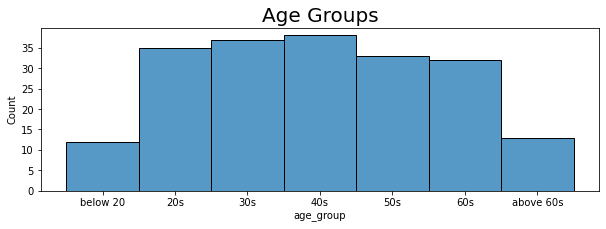

In [15]:
plt.figure(figsize=(10,3))
sns.histplot(drugs['age_group'])
plt.title('Age Groups', size=20)
plt.show()

- Now it looks like a very good Gaussian Distribution 

### `Sex`

In [16]:
drugs['Sex'].value_counts()

M    104
F     96
Name: Sex, dtype: int64

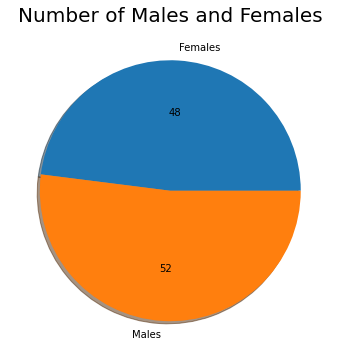

In [17]:
plt.figure(figsize=(6,6))
drugs.groupby('Sex').size().plot(kind='pie', 
                                 autopct='%.0f', 
                                 labels=['Females', 'Males'], 
                                 shadow=True)
plt.title('Number of Males and Females', 
          size=20)
plt.ylabel(None)
plt.show()

- Both genders are almost equally present in the dataset

### `BP`

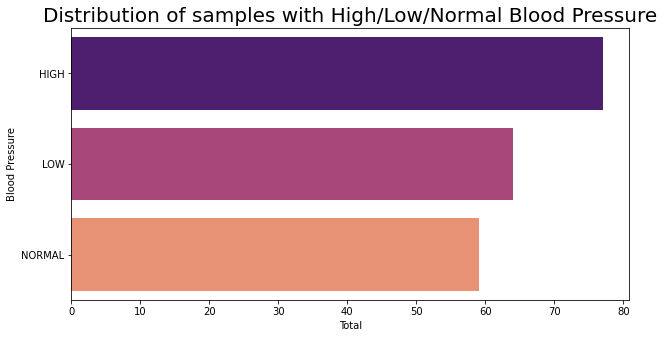

In [18]:
plt.figure(figsize=(10,5))
sns.countplot(y='BP', data=drugs, palette='magma')
plt.ylabel('Blood Pressure')
plt.xlabel('Total')
plt.title('Distribution of samples with High/Low/Normal Blood Pressure', 
          size=20)
plt.show()

- In the dataset, people with high blood pressures are the most frequent, followed by the people with low and then, normal blood pressures

### `Cholesterol`

In [19]:
drugs['Cholesterol'].value_counts()

HIGH      103
NORMAL     97
Name: Cholesterol, dtype: int64

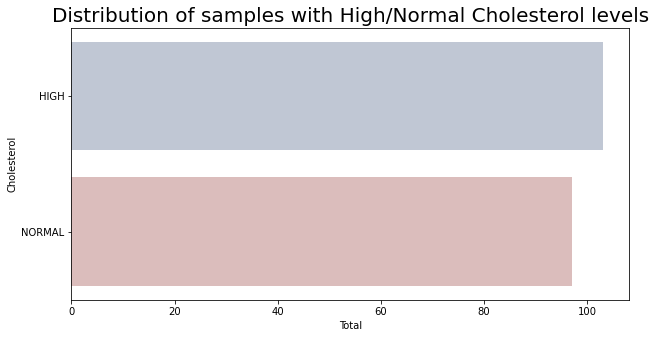

In [20]:
plt.figure(figsize=(10,5))
sns.countplot(y='Cholesterol', data=drugs, palette='vlag')
plt.ylabel('Cholesterol')
plt.xlabel('Total')
plt.title('Distribution of samples with High/Normal Cholesterol levels', 
          size=20)
plt.show()

- This distribution is nearly balanced as well.


### `Na_to_K`

In [21]:
drugs.describe()['Na_to_K'].loc[['min','max']]

min     6.269
max    38.247
Name: Na_to_K, dtype: float64

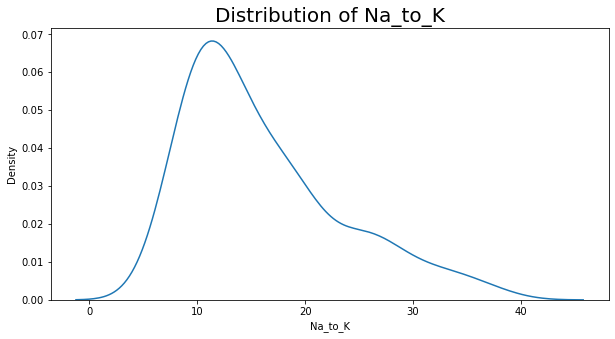

In [22]:
plt.figure(figsize=(10,5))
sns.kdeplot(drugs['Na_to_K'])
plt.ylabel('Density')
plt.xlabel('Na_to_K')
plt.title('Distribution of Na_to_K', 
          size=20)
plt.show()

- The only continuous variable, `Na_to_K` has a rightly skewed normal distribution

### The target variable, `Drug`

In [23]:
drugs['Drug'].value_counts()

DrugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: Drug, dtype: int64

In [24]:
print('Distribution of Drugs percentage-wise')
drugs['Drug'].value_counts(normalize=True)*100

Distribution of Drugs percentage-wise


DrugY    45.5
drugX    27.0
drugA    11.5
drugC     8.0
drugB     8.0
Name: Drug, dtype: float64

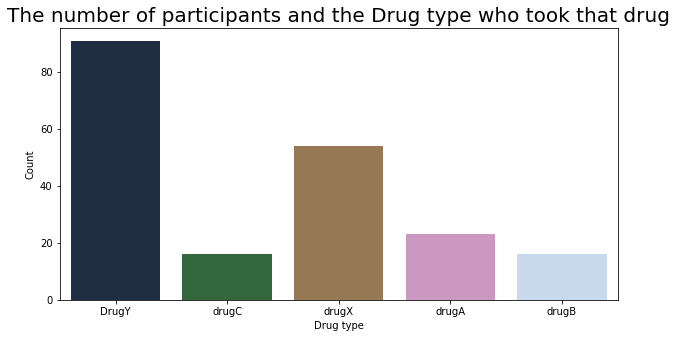

In [25]:
plt.figure(figsize=(10,5))
sns.countplot(x=drugs['Drug'], palette='cubehelix')
plt.ylabel('Count')
plt.xlabel('Drug type')
plt.title('The number of participants and the Drug type who took that drug', 
          size=20)
plt.show()

- As expected with most of the Multiclassification problems, we have a highly imbalanced distribution.
- Nearly the half of the participants were administered `DrugY`

I think a further investigation is pertinent before considering its treatment

In [26]:
def plot_comparisons(col, data=drugs):
    '''
    The function plots frequency distributions
    charts of the column against the target var
    'Drug'. 
    For numerical columns, it uses swarmplot. 
    Whereas for the Categorical column, it uses
    countplot to display the frequenct charts
    
    Args:
        col: The feature
        data: drugs by default
        
    Returns:
        A plot of desired comparison
        
    '''
    plt.figure(figsize=(10,5))
    if col in ['Age', 'Na_to_K']:
        sns.swarmplot(data=drugs, 
              x='Drug', 
              y=col)
    else:
        sns.countplot(data=drugs,
                      x='Drug',
                      hue=col)
    plt.title('Drug vs {}'.format(col))
    plt.show()


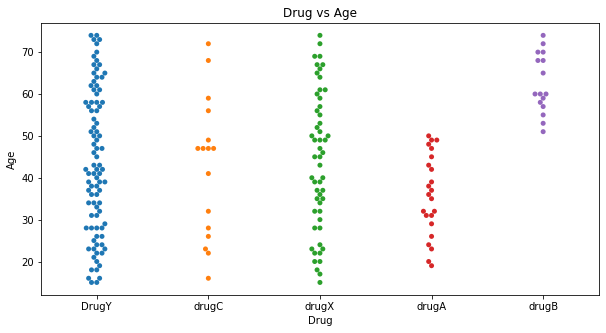

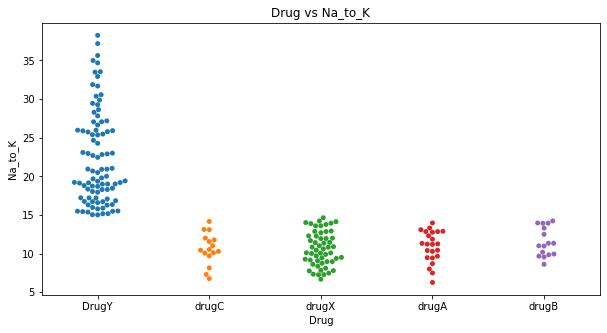

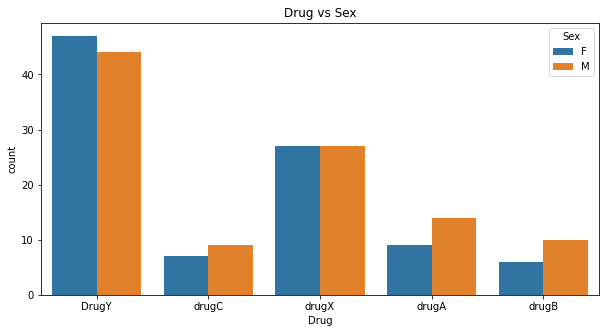

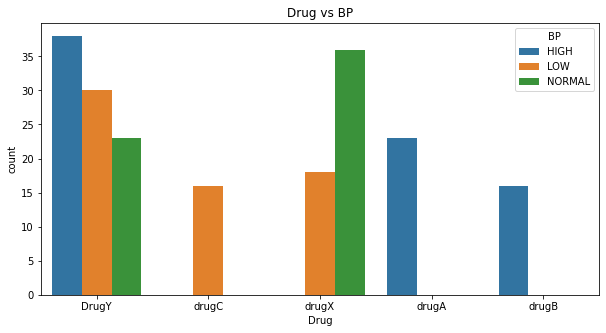

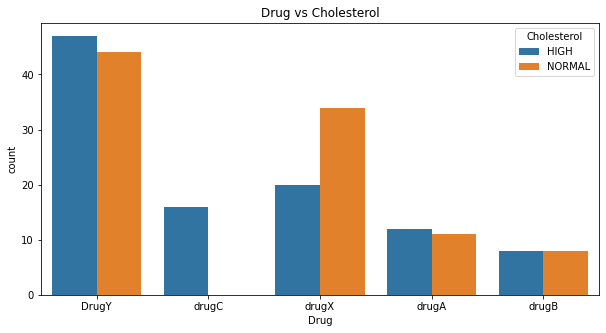

In [27]:
consider_cols = ['Age', 'Na_to_K', 'Sex', 'BP', 'Cholesterol']
for col in consider_cols:
    plot_comparisons(col)

In [28]:
bool_a = drugs['Drug'] == 'drugA'
bool_b = drugs['Drug'] == 'drugB'
print('Max Age of drugA takers: ',drugs.loc[bool_a, 'Age'].max())
print('Min Age of drugB takers: ',drugs.loc[bool_b, 'Age'].min())

Max Age of drugA takers:  50
Min Age of drugB takers:  51


#### Insights:
- Some interesting insights can be seen here.
    1. The `DrugA` was only prescribed to the people **younger than the 51 years old**. The `DrugB` was prescribed to the people **older than 50**
    2. The **`Sex`** gender didn't play any role in the choice of drug
    3. **`BP`** also had a decisive part to play in the choice of drug.
    
        - `DrugC` was only given to those with LOW BP.
        - `DrugA` and `DrugB` was only given to those with High BP
        - Whereas the `DrugX` was not given to those with High BP
    4. The `DrugC` was only given to those with High Cholesterol levels

Based on the above insights, I think the following features will contribute a lot to the predictory performance of the model.
- Whether the participant is older than 50 yo
- Whether the participant has higher Na_to_K levels than 15
- The other features shall already appear once we are done with One-Hot-Encoding

So lets move on to Feature Engineering

---

## Feature Engineering

Here, I will be creating the columns discussed previously as well as some other necessary Encodings such as 
- For the columns `Sex`,`age_group`, `above_50_age`, and `above_15_Na_to_K` OneHotEncoding shall be performed
- For the columns `BP`, and `Cholesterol`, LabelEncoding seems more relevant. For now, I'd still opt for OHE.

In [29]:
# Is the participant >= 15yo
drugs['above_50_age'] = drugs['Age'].apply(lambda x: 1 if x >= 50 else 0 )

In [30]:
# Is the participant having Na_to_K levels >= 15
drugs['above_15_Na_to_K'] = drugs['Na_to_K'].apply(lambda x: 1 if x >=15 else 0)

In [31]:
# Age categories
age_bins = [0, 19, 29, 39, 49, 59, 69, 80]
age_cats = ['below 20', '20s', '30s', '40s', '50s', '60s', 'above 60s']
drugs['age_group'] = pd.cut(drugs['Age'], 
                            bins=age_bins, 
                            labels=age_cats)

In [32]:
# Contender cols for OHE
cols_ohe = ['Sex', 'BP', 'Cholesterol', 'age_group']

# Instantiating the Encoder
ohe_encoder = OneHotEncoder(drop='first', sparse=False)

# Fit and Transform
onehot = ohe_encoder.fit_transform(drugs[cols_ohe])

In [33]:
# Perform Label encoding on the target variable
col_le = ['Drug']
le_encoder = LabelEncoder()
lenc = le_encoder.fit_transform(drugs['Drug'])

In [34]:
# Following are the labels given to the classes
le_name_mapping = dict(zip(le_encoder.classes_, le_encoder.transform(le_encoder.classes_)))
print('Following is the mapping of class to label\n',le_name_mapping)
ser_class_to_label = pd.Series(le_name_mapping)


Following is the mapping of class to label
 {'DrugY': 0, 'drugA': 1, 'drugB': 2, 'drugC': 3, 'drugX': 4}


In [35]:
# Make a DF out of arrays
df_ohe = pd.DataFrame(onehot, columns=ohe_encoder.get_feature_names_out())

# Concatenate the exluded columns
df = pd.concat([df_ohe, drugs[['Age', 'Na_to_K','above_50_age', 'above_15_Na_to_K']]], axis=1)
df['Drug_le'] = lenc

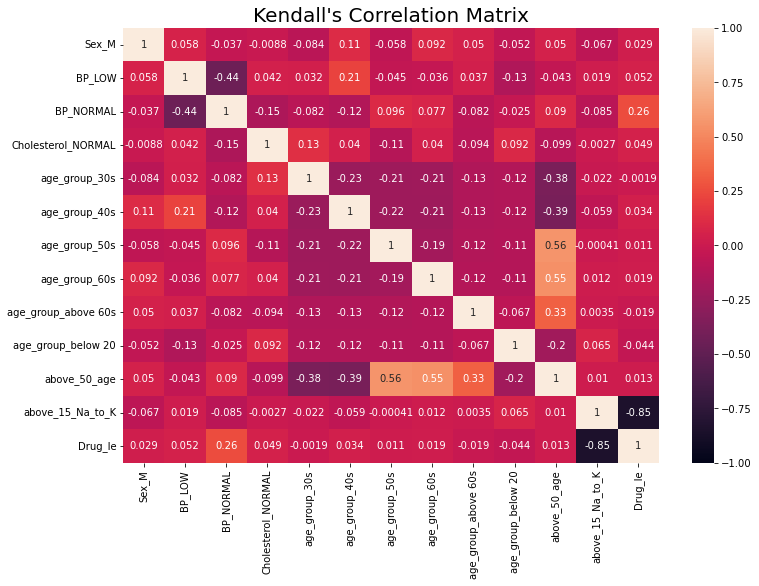

In [36]:
# Keeping only Categorical columns to check Kendall's Correlation
df_catcols = df.loc[:, ~df.columns.isin(['Age', 'Na_to_K'])]

# plot
plt.figure(figsize=(12,8))
sns.heatmap(df_catcols.corr(method='kendall'), vmin=-1, vmax=1, annot=True)
plt.title('Kendall\'s Correlation Matrix', size=20)
plt.show()

- As expected, we can find hints of Collinearity between the features `age_group_50s` and `above_50_age`. The feature `age_group_60s` and `above_50_age` also seems to be collinear. 
- `above_15_Na_to_K` seems to be highly efficient predictor, however, this could be misleading as well. Since the mentioned feature is a very good predictor of a single Drug type

In [37]:
# the independent variables set
X = df.iloc[:,:-1]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
  
# calculating VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                feature        VIF
0                 Sex_M   2.107615
1                BP_LOW   1.970436
2             BP_NORMAL   1.846576
3    Cholesterol_NORMAL   2.051082
4         age_group_30s   3.492484
5         age_group_40s   5.786254
6         age_group_50s        inf
7         age_group_60s        inf
8   age_group_above 60s        inf
9    age_group_below 20   1.254374
10                  Age  57.890288
11              Na_to_K  15.721879
12         above_50_age        inf
13     above_15_Na_to_K   5.012252


G:\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


- Features such as `age_group_50s`, `age_group_60s`, `age_group_above_60s`, and `above_50_age` have infinite VIF. We must get rid of them and recalculate the VIF

In [38]:
# Removing the columns 
df1 = df.drop(['age_group_50s', 'age_group_60s', 'age_group_above 60s', 'Age'], axis=1)

In [39]:
# the independent variables set
X = df1.iloc[:,:-1]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
  
# calculating VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

              feature       VIF
0               Sex_M  1.963053
1              BP_LOW  1.851255
2           BP_NORMAL  1.552479
3  Cholesterol_NORMAL  1.970528
4       age_group_30s  1.718898
5       age_group_40s  1.888343
6  age_group_below 20  1.250939
7             Na_to_K  9.141501
8        above_50_age  2.545386
9    above_15_Na_to_K  4.336291


- Looks much better. I have reduced the MultiCollinearity to a great extent

Having done with most of the exploratory and pre-processing parts, lets move on to the next.

It should be recalled that **the target variable is highly imbalanced** 

---
To handle it, there are a couple of options such as over-sampling or under-sampling techniques. I'll opt for SMOTE to treat the imbalance

## The Pipeline and Modelling
- Please note that for Scaling purposes, StandardScaler shall be used. 
- Whereas for Over-Sampling to treat Class imbalance, SMOTE technique shall be utilized

In [40]:
# Separating Features and Target
X = df1.iloc[:,:-1]
y = df1.iloc[:,-1]

In [41]:
# List of algorithms
models = [('knn', KNeighborsClassifier()), 
          ('lr', LogisticRegression()), 
          ('svm', LinearSVC()), 
          ('dtree', DecisionTreeClassifier()), 
          ('rf', RandomForestClassifier())]

# List of all the steps
all_my_steps = []
for name, model in models:
    # Since Linear models as well as KNN require Scaling
    if name in ['knn', 'svm', 'lr']:
        my_steps = [('ovs', SMOTE()), ('scaler',StandardScaler()), (name, model)]
        all_my_steps.append(my_steps)
    # Whereas Tree based models do not require scaling
    else:
        my_steps = [('ovs', SMOTE()),  (name, model)]
        all_my_steps.append(my_steps)

In [42]:
def pipe_cv(my_steps):
    '''
    The function uses Cross Validation with Stratified folds
    Args:
        my_steps: list of steps 
    Return:
        Mean Accuracy scores
    '''
    # Create pipeline
    pipeline = Pipeline(steps=my_steps)
    # Setup CrossValidation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # Compute mean accuracy
    score = np.mean(scores)
    print((score))

# Use the function for all the possible steps in all_my_steps
for my_steps in all_my_steps:
    pipe_cv(my_steps)

0.925
0.995
0.995
0.9933333333333334
0.9933333333333334


- These are some overwhelmingly optimistic results. 

Lets evaluate to dig into the results and scores for each algorithm

In [43]:
def evaluate(X, y, my_steps):
    '''
    This function evaluates the model using
    train_test_split method and returns with
    a detailed performance metrices
    Args:
        X: The labels
        y: The target
        my_steps: Steps for the pipeline
    Returns:
        Accuracy, Classification Report as well
        as the Confusion Matrix for each pipeline
    '''
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    # Pipeline using the designated steps
    pipeline = Pipeline(my_steps)
    # Fit the pipeline
    pipeline.fit(X_train, y_train)
    # Predict
    y_pred = pipeline.predict(X_test)
    # Classification Report
    cls_report = classification_report(y_test, y_pred)
    # Print the results
    print('Algorithm: {}'.format(my_steps[-1][1]))
    print('\n')
    print(cls_report)
    # Display Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
    disp.plot()
    plt.show()
    print('-'*75,'\n')
    
    

Algorithm: KNeighborsClassifier()


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      0.75      0.86         4
           2       0.67      1.00      0.80         6
           3       0.60      0.75      0.67         4
           4       1.00      0.84      0.91        19

    accuracy                           0.92        60
   macro avg       0.85      0.87      0.85        60
weighted avg       0.94      0.92      0.92        60



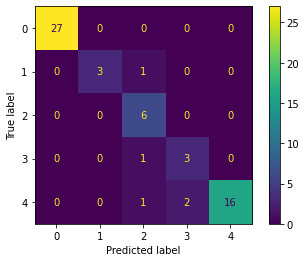

--------------------------------------------------------------------------- 

Algorithm: LogisticRegression()


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      0.75      0.86         4
           2       0.86      1.00      0.92         6
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00        19

    accuracy                           0.98        60
   macro avg       0.97      0.95      0.96        60
weighted avg       0.99      0.98      0.98        60



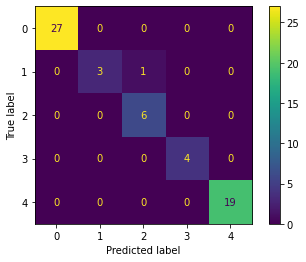

--------------------------------------------------------------------------- 

Algorithm: LinearSVC()


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      0.75      0.86         4
           2       0.86      1.00      0.92         6
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00        19

    accuracy                           0.98        60
   macro avg       0.97      0.95      0.96        60
weighted avg       0.99      0.98      0.98        60



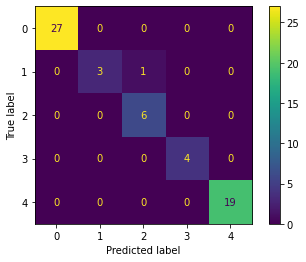

--------------------------------------------------------------------------- 

Algorithm: DecisionTreeClassifier()


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      0.75      0.86         4
           2       0.86      1.00      0.92         6
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00        19

    accuracy                           0.98        60
   macro avg       0.97      0.95      0.96        60
weighted avg       0.99      0.98      0.98        60



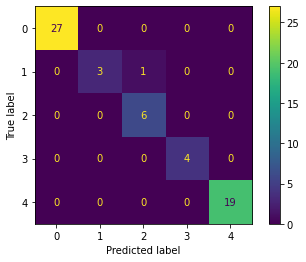

--------------------------------------------------------------------------- 

Algorithm: RandomForestClassifier()


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      0.75      0.86         4
           2       0.86      1.00      0.92         6
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00        19

    accuracy                           0.98        60
   macro avg       0.97      0.95      0.96        60
weighted avg       0.99      0.98      0.98        60



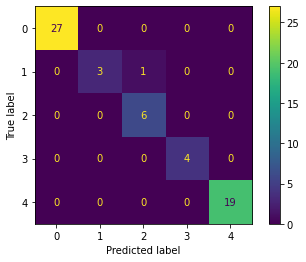

--------------------------------------------------------------------------- 



In [44]:
# Use the function for all the possible steps in all_my_steps
for my_steps in all_my_steps:
    evaluate(X,y, my_steps)

### Insights
- KNeighborsClassifier does not seem working well for the majority of the drug classes. 
- Other Linear models such as LogisticRegression and LinearSVC have similar performances, though much better than KNeighborsClassifier.
- RandomForestClassifier and DecisionTreeClassifier look the best options to go ahead with

#### Hyperparameter Optimization
for RandomForestClassifier

In [45]:
# Define Parameters
max_depth=np.arange(2,20,4)
n_estimators = np.arange(32,128,16)
param_grid = dict(randomforestclassifier__max_depth=max_depth, 
                  randomforestclassifier__n_estimators=n_estimators)

In [46]:
param_grid

{'randomforestclassifier__max_depth': array([ 2,  6, 10, 14, 18]),
 'randomforestclassifier__n_estimators': array([ 32,  48,  64,  80,  96, 112])}

Though the data is extremely small, but lets use the convention of validation sets 

In [47]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Re-Split the data into val and train to avoid data leakage
X_val_train, X_val_test, y_val_train, y_val_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


pipe_rf = make_pipeline(SMOTE(), 
                       RandomForestClassifier())

gscv = GridSearchCV(estimator=pipe_rf, 
                    param_grid=param_grid, 
                    scoring='accuracy', 
                    cv=5, 
                    refit=True, 
                    n_jobs=-1)

gscv = gscv.fit(X_val_train, y_val_train)
print('The best score I got: ', gscv.best_score_)
print('\n')
print('Using these params: ', gscv.best_params_)

The best score I got:  0.992


Using these params:  {'randomforestclassifier__max_depth': 6, 'randomforestclassifier__n_estimators': 32}


Finally, lets use the obtained params to build our model on

In [48]:
# Obtaining the best params and modelling over them
final_model = gscv.best_estimator_
final_model.fit(X_train, y_train)

print('The score by model is: ', model.score(X_test, y_test))

The score by model is:  1.0


In [49]:
final_model

Pipeline(steps=[('smote', SMOTE()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=6, n_estimators=32))])

Algorithm: RandomForestClassifier(max_depth=6, n_estimators=48)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      0.75      0.86         4
           2       0.86      1.00      0.92         6
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00        19

    accuracy                           0.98        60
   macro avg       0.97      0.95      0.96        60
weighted avg       0.99      0.98      0.98        60



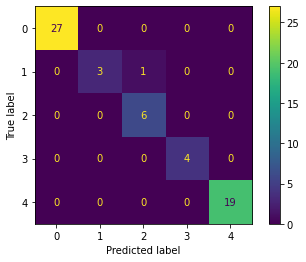

--------------------------------------------------------------------------- 



In [50]:
evaluate(X, y, [('smote', SMOTE()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=6, n_estimators=48))])

In [49]:
ser_class_to_label

DrugY    0
drugA    1
drugB    2
drugC    3
drugX    4
dtype: int32

---

# Conclusion
- So far, we have achieved perfect accuracy in predicting the Drug Class using SMOTE followed by the RandomForestsClassifier modelled with the parameters 
    - `max_depth`: *6*
    - `n_estimators`: *48*
- We still have a good precision for the `DrugB` and a satisfactory recall for `DrugA`

- What more can be done here? 
    - I think that there is still a room to play around with Hyperparameter Optimization. I took largely spaced params to find the clues. However, I think that the perfomance is satisfactory
    

I'd welcome any feedback, as that's how our data community is learning and growing itself.


Thank you very much for your considerations, 

S M Ali :)

[LinkedIn's Profile](https://www.linkedin.com/in/s-m-ali-rizvi-a1b550217/) and 
[Github Portfolio](https://github.com/letdatado)
